# Confidence Simulations with Pilot Responses 10% Hazard

1. Read in data from PilotData4 (hazard rate 10%; survey)
2. Simulate confidences:
    1. Normative
    2. ~~Restricted normative (using subject's window)~~
    3. Normative + 20% noise
    4. ~~Restricted normative + 20% noise~~
    5. Random
3. Compute I_past, I_future for task only, task + confidence, confidence only (maybe start with one subject)
4. Compare differences/ratios of I_past for different confidence simulations
5. Compare differences/ratios of I_future for different confidence simulations

In [124]:
#import importlib
#importlib.reload(sm)

<module 'smfile' from '/Users/vwang/Documents/PennMed/Gold Lab/Preregistration/Urn-Confidence/Pilot/smfile.py'>

In [120]:
import pandas as pd
import numpy as np
from embo import InformationBottleneck
import HMM_beads_utils as ut
import smfile as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os,ndd,pickle
from adjustText import adjust_text
cmap = plt.get_cmap("tab10")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [132]:
D = pd.read_csv("PilotData4_munged.csv", dtype = {'History': str})

In [133]:
D['Subject'].unique()
D

array(['5ebd', '5e9d', '5da7', '60ce', '5f52', '60c8'], dtype=object)

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,5ebd,10,0,1,0,0,0,00011101101
1,5ebd,11,0,0,1,1,0,00111011011
2,5ebd,12,0,0,0,1,1,01110110110
3,5ebd,13,1,0,0,1,1,01101101100
4,5ebd,14,0,1,0,1,0,01011011000
...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011
5996,60c8,1006,0,0,1,0,0,01101110110
5997,60c8,1007,0,0,0,0,1,01011101100
5998,60c8,1008,0,0,0,0,1,00111011000


In [134]:
for sub in D['Subject'].unique():
    subD = D[D['Subject'] == sub].reset_index()
    normative = sm.gen_sim_pred(sub,subD['Bead'],subD['Jar'],subD['Trial'],p = 0.8,h = 0.1)
    D.loc[D['Subject'] == sub, 'Posterior'] = normative['Posterior'].values
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Posterior
0,5ebd,10,0,1,0,0,0,00011101101,0.800000
1,5ebd,11,0,0,1,1,0,00111011011,0.415730
2,5ebd,12,0,0,0,1,1,01110110110,0.160083
3,5ebd,13,1,0,0,1,1,01101101100,0.068782
4,5ebd,14,0,1,0,1,0,01011011000,0.423256
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.582853
5996,60c8,1006,0,0,1,0,0,01101110110,0.246087
5997,60c8,1007,0,0,0,0,1,01011101100,0.095475
5998,60c8,1008,0,0,0,0,1,00111011000,0.050817


In [150]:
D_n = D.copy()
D_s = D.copy()
D_r = D.copy()

Ddict = {'orig': D, 'normative': D_n, 'normslop': D_s, 'random': D_r}

In [151]:
D_n['Confidence'] = D_n.groupby(['Subject'], group_keys=False).apply(lambda g: abs(0.5 - g.Posterior) > abs(0.5 - g.Posterior).median())*1
D_s['Confidence'] = sm.add_noise(D_n['Confidence'],0.1)
D_r['Confidence'] = sm.add_noise(D_n['Confidence'],1)

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

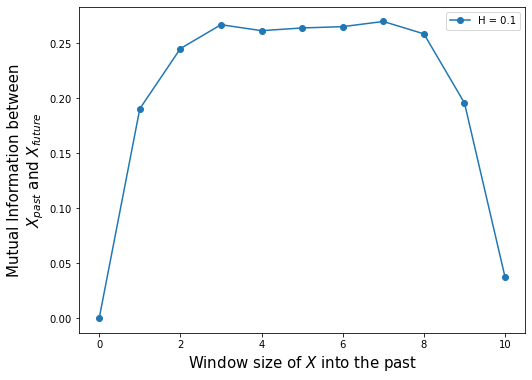

In [137]:
maxw = 10

bound_seq = D[D['Subject'] == D['Subject'].unique()[2]].copy()
bound_seq['History'] = sm.get_previous_n_beads(maxw, bound_seq['Bead'])

# Computed windowed predictive information in the low hazard rate
window_mi = sm.get_windowed_mi(bound_seq['History'],
                              bound_seq['Jar'],maxw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(maxw+1),window_mi,'-o',label='H = 0.1')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, '$I_{past}$')

Text(0, 0.5, '$I_{future}$')

Text(0.5, 1.0, 'Low confidence')

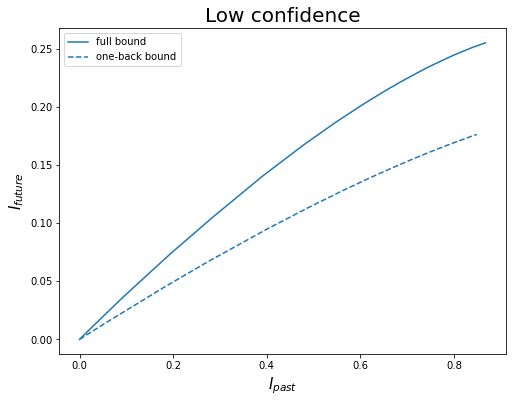

In [138]:
ip_fullbound,if_fullbound,ip_1backbound,if_1backbound = sm.get_windowed_bound(bound_seq['History'],
                                                             bound_seq['Jar'],6)

    
# Plot bounds
plt.figure(1,(8,6))

# Low confidence rate
#plt.subplot(1,2,1)
plt.plot(ip_fullbound,if_fullbound,'-',color=cmap(0),label='full bound')
plt.plot(ip_1backbound,if_1backbound,'--',color=cmap(0), label='one-back bound')
#plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low confidence',size=20)
plt.legend()

In [139]:
D

,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History,Posterior
0,5ebd,10,0,1,0,0,0,00011101101,0.800000
1,5ebd,11,0,0,1,1,0,00111011011,0.415730
2,5ebd,12,0,0,0,1,1,01110110110,0.160083
3,5ebd,13,1,0,0,1,1,01101101100,0.068782
4,5ebd,14,0,1,0,1,0,01011011000,0.423256
...,...,...,...,...,...,...,...,...,...
5995,60c8,1005,0,0,1,1,0,01110111011,0.582853
5996,60c8,1006,0,0,1,0,0,01101110110,0.246087
5997,60c8,1007,0,0,0,0,1,01011101100,0.095475
5998,60c8,1008,0,0,0,0,1,00111011000,0.050817


In [158]:
Ip = {} 
If = {} 
for dname,d in Ddict.items():
    ip_task,if_task = sm.get_windowed_mi_subs(d,6)
    ip_conf, if_conf = sm.get_windowed_mi_subs_confo(d,6)
    ip_both, if_both = sm.get_windowed_mi_subs_confid(d,6)
    
    for sub in ip_task.keys():
        Ip[(sub, dname, 'task')] = ip_task[sub]
        Ip[(sub, dname, 'conf')] = ip_conf[sub]
        Ip[(sub, dname, 'both')] = ip_both[sub]        
        If[(sub, dname, 'task')] = if_task[sub]
        If[(sub, dname, 'conf')] = if_conf[sub]
        If[(sub, dname, 'both')] = if_both[sub]
#Ip
#If

In [ ]:
nboot = 1000
Ip_boot = []
If_boot = []
for dname,d in Ddict.items():
    ip_task_boot, if_task_boot = get_bootstrapped_samples(D,ips_sub_task,nboot)
    ip_conf_boot, if_conf_boot = get_bootstrapped_samples_confo(D,ips_sub_conf,nboot)
    ip_both_boot, if_both_boot = get_bootstrapped_samples_confid(D,ips_sub_both,nboot)
    
    

In [ ]:
nboot = 1000 #number of bootstrapped samples

ip_h1_boot, if_h1_boot = get_bootstrapped_samples(D,ips_sub_h1,nboot)
ip_mean_h1 = np.array([np.mean(ip_h1_boot[key]) for key in ip_h1_boot.keys()])
ip_95CI_h1 = np.array([np.std(ip_h1_boot[key])*1.96 for key in ip_h1_boot.keys()])
if_mean_h1 = np.array([np.mean(if_h1_boot[key]) for key in if_h1_boot.keys()])
if_95CI_h1 = np.array([np.std(if_h1_boot[key])*1.96 for key in if_h1_boot.keys()])

ip_confid_boot, if_confid_boot = get_bootstrapped_samples_confid(D,ips_sub_confid,nboot)
ip_mean_confid = np.array([np.mean(ip_confid_boot[key]) for key in ip_confid_boot.keys()])
ip_95CI_confid = np.array([np.std(ip_confid_boot[key])*1.96 for key in ip_confid_boot.keys()])
if_mean_confid = np.array([np.mean(if_confid_boot[key]) for key in if_confid_boot.keys()])
if_95CI_confid = np.array([np.std(if_confid_boot[key])*1.96 for key in if_confid_boot.keys()])

ip_confo_boot, if_confo_boot = get_bootstrapped_samples_confo(D,ips_sub_confo,nboot)
ip_mean_confo = np.array([np.mean(ip_confo_boot[key]) for key in ip_confo_boot.keys()])
ip_95CI_confo = np.array([np.std(ip_confo_boot[key])*1.96 for key in ip_confo_boot.keys()])
if_mean_confid = np.array([np.mean(if_confid_boot[key]) for key in if_confid_boot.keys()])
if_95CI_confid = np.array([np.std(if_confid_boot[key])*1.96 for key in if_confid_boot.keys()])

In [ ]:
   
plt.figure(1,(15,5))
# Low confidence
plt.subplot(1,2,1)
for sub in pd.unique([key for key in ips_sub_h1.keys()]):
    plt.plot(np.arange(len(ips_sub_h1[sub])),ips_sub_h1[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('Low confidence',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')
    
# High confidence
plt.subplot(1,2,2)
for sub in pd.unique([key for key in ips_sub_confid.keys()]):
    plt.plot(np.arange(len(ips_sub_confid[sub])),ips_sub_confid[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('Low confidence',size=20)
    #plt.ylim([0,1])
    plt.legend(loc = 'lower right')

In [ ]:
colors = dict(zip(set([key.split("_")[0] for key in ip_h1_boot.keys()]), [cmap(i) for i in np.arange(len(set([key.split("_")[0] for key in ip_h1_boot.keys()])))]))

h1_subs = np.array([key.split("_")[0] for key in ip_h1_boot.keys()])
h1_colors = np.array([colors[i] for i in h1_subs])


plt.figure(1,(15,5))
# Low confidence
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_h1,if_mean_h1)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_h1,if_mean_h1,h1_colors, ip_95CI_h1,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Low confidence',size=20)
#plt.ylim([0,1])





plt.figure(1,(30,10))
# Low confidence
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_confid,if_mean_confid)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_confid,if_mean_confid,confid_colors, ip_95CI_confid,if_95CI_confid ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_confid_boot.keys()): 
    texts.append(plt.text(ip_mean_confid[i],if_mean_confid[i],sub+"_confid"))
    
for i_p,i_f,col,xe,ye in zip(ip_mean_h1,if_mean_h1,h1_colors, ip_95CI_h1,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
    
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'), size = 15)
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
#plt.ylim([0,1])










plt.figure(1,(30,10))
# Low confidence
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_confid,if_mean_confid)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
for i_p,i_f,col,xe,ye in zip(ip_mean_confid,if_mean_confid,confid_colors, ip_95CI_confid,if_95CI_confid ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_confid_boot.keys()): 
    texts.append(plt.text(ip_mean_confid[i],if_mean_confid[i],sub+"_confid"))
    
for i_p,i_f,col,xe,ye in zip(ip_mean_h1,if_mean_h1,h1_colors, ip_95CI_h1,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
    
for i_p,i_f,col,xe,ye in zip(ip_mean_confo,if_mean_h1,h1_colors, ip_95CI_confo,if_95CI_h1 ):
    plt.errorbar(i_p,i_f,xerr=xe,yerr = ye,
             marker='o',markersize=9,mec='white',color=col,ls='none')
    
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Decision only vs decision + confidence',size=20)
#plt.ylim([0,1])